## MM

In [ ]:
from agent import DQNMMAgent
import logging
from tqdm.auto import tqdm
import random

logger = logging.getLogger()
logger.disabled = True

params_all = []
for test_seed in range(5):
    num_iterations = 100 * 100
    batch_size = 32
    question_interval = 1
    room_size = "l"
    capacity = {
        "episodic": 16,
        "episodic_agent": 0,
        "semantic": 16,
        "semantic_map": 0,
        "short": 1,
    }
    terminates_at = 99
    params = {
        "env_str": "room_env:RoomEnv-v2",
        "num_iterations": num_iterations,
        "replay_buffer_size": num_iterations,
        "warm_start": num_iterations // 10,
        "batch_size": batch_size,
        "target_update_interval": 10,
        "epsilon_decay_until": num_iterations,
        "max_epsilon": 1.0,
        "min_epsilon": 0.1,
        "gamma": 0.99,
        "capacity": capacity,
        "pretrain_semantic": False,
        "nn_params": {
            "hidden_size": 64,
            "num_layers": 2,
            "embedding_dim": 64,
            "make_categorical_embeddings": False,
            "memory_of_interest": [
                "episodic",
                "semantic",
                "short",
            ],
            "fuse_information": "sum",
            "include_positional_encoding": True,
            "max_timesteps": 100,
            "max_strength": 100,
        },
        "run_test": True,
        "num_samples_for_results": 10,
        "plotting_interval": 10,
        "train_seed": test_seed + 5,
        "test_seed": test_seed,
        "device": "cpu",
        "qa_policy": "episodic_semantic",
        "explore_policy": "avoid_walls",
        "env_config": {
            "question_prob": 1.0,
            "terminates_at": 99,
            "randomize_observations": "objects",
            "room_size": room_size,
            "rewards": {"correct": 1, "wrong": 0, "partial": 0},
            "make_everything_static": False,
            "num_total_questions": 1000,
            "question_interval": question_interval,
            "include_walls_in_observations": True,
            "deterministic_objects": False,
        },
        "ddqn": True,
        "dueling_dqn": True,
        "default_root_dir": "./training-results/episodic-semantic",
        "run_handcrafted_baselines": False,
    }
    params_all.append(params)

for params in tqdm(params_all):
    agent = DQNMMAgent(**params)
    agent.train()

## Explore

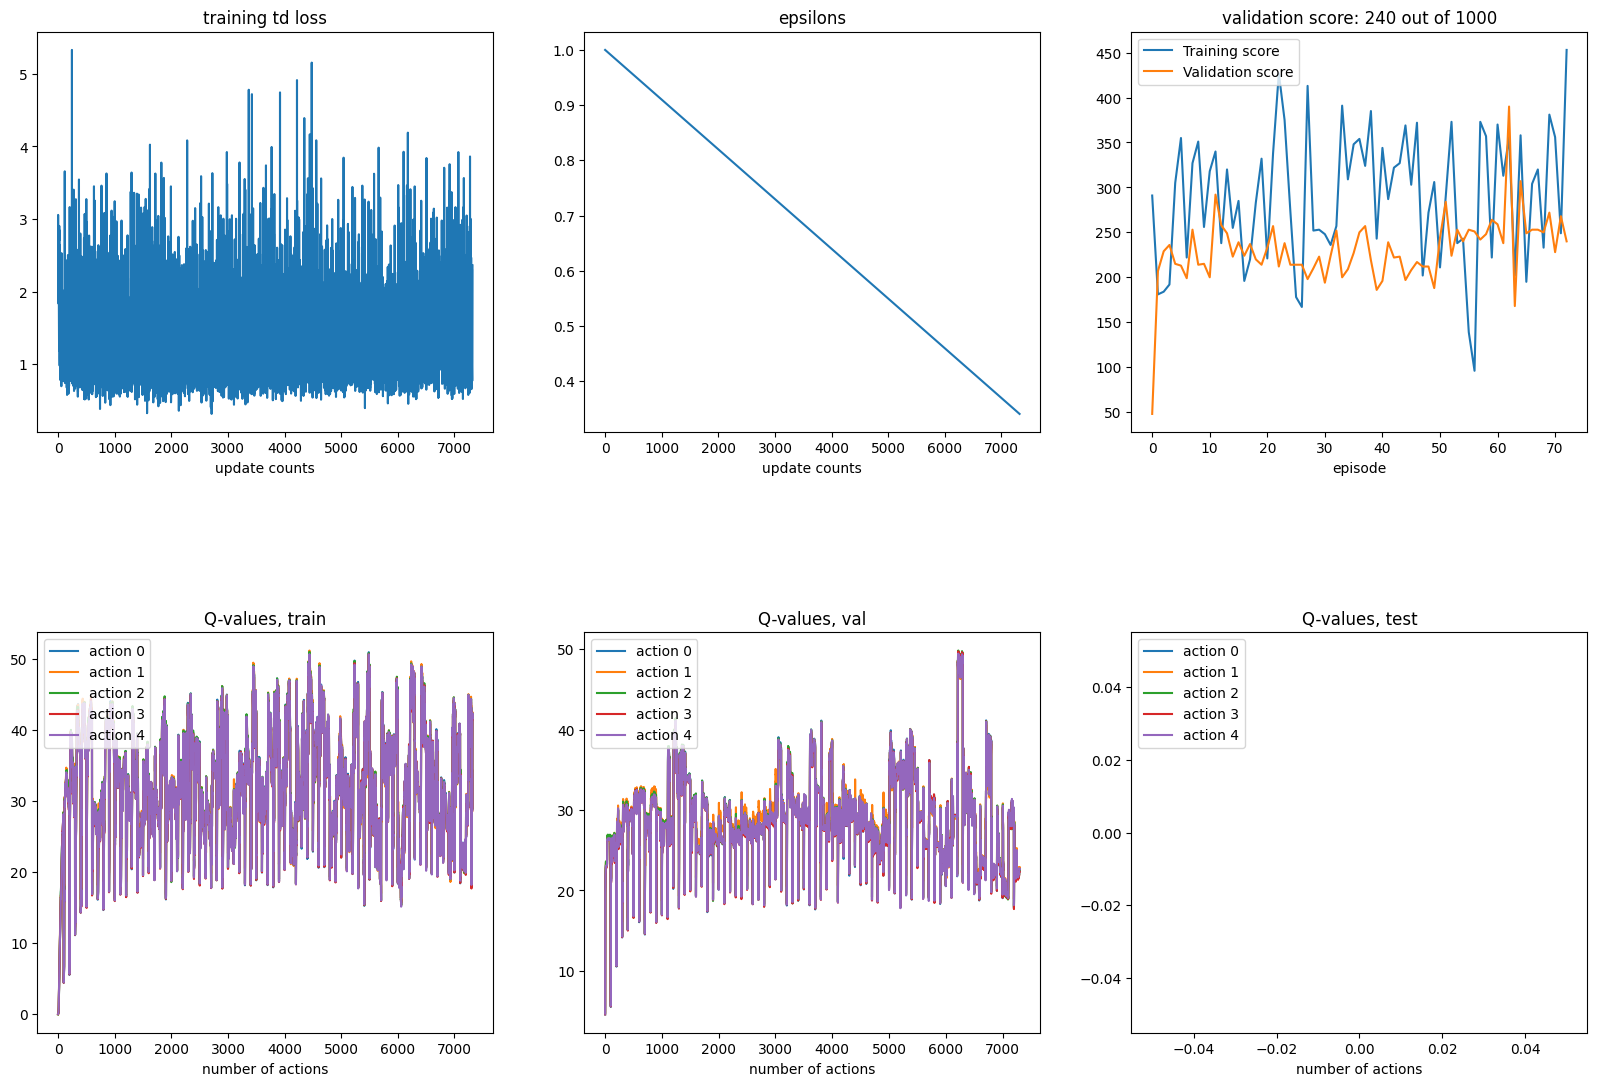

In [1]:
from agent import DQNExploreAgent
import logging
from tqdm.auto import tqdm
import random

logger = logging.getLogger()
logger.disabled = True

params_all = []
for test_seed in range(5):
    num_iterations = 100 * 100
    batch_size = 32
    question_interval = 1
    room_size = "l"
    capacity = {
        "episodic": 16,
        "episodic_agent": 0,
        "semantic": 16,
        "semantic_map": 0,
        "short": 1,
    }
    terminates_at = 99

    mm_agent_path = "./training-results/episodic-semantic/2024-06-20 10:14:57.119065/agent.pkl"

    params = {
        "env_str": "room_env:RoomEnv-v2",
        "num_iterations": num_iterations,
        "replay_buffer_size": num_iterations,
        "warm_start": num_iterations // 10,
        "batch_size": batch_size,
        "target_update_interval": 10,
        "epsilon_decay_until": num_iterations,
        "max_epsilon": 1.0,
        "min_epsilon": 0.1,
        "gamma": 0.9,
        "capacity": capacity,
        "pretrain_semantic": False,
        "nn_params": {
            "hidden_size": 64,
            "num_layers": 2,
            "embedding_dim": 64,
            "make_categorical_embeddings": False,
            "memory_of_interest": [
                "episodic",
                "semantic",
            ],
            "fuse_information": "sum",
            "include_positional_encoding": True,
            "max_timesteps": 100,
            "max_strength": 100,
        },
        "run_test": True,
        "num_samples_for_results": 10,
        "train_seed": test_seed + 5,
        "test_seed": test_seed,
        "device": "cpu",
        "mm_policy": "neural",
        "mm_agent_path": mm_agent_path,
        "qa_policy": "episodic_semantic",
        "env_config": {
            "question_prob": 1.0,
            "terminates_at": 99,
            "randomize_observations": "objects",
            "room_size": room_size,
            "rewards": {"correct": 1, "wrong": 0, "partial": 0},
            "make_everything_static": False,
            "num_total_questions": 1000,
            "question_interval": question_interval,
            "include_walls_in_observations": True,
            "deterministic_objects": False,
        },
        "ddqn": True,
        "dueling_dqn": True,
        "default_root_dir": "./training-results/episodic-semantic/explore/",
        "run_neural_baseline": True,
    }
    params_all.append(params)

for params in tqdm(params_all):
    agent = DQNExploreAgent(**params)
    agent.train()